<img src="https://www.mercari.com/assets/img/help_center/us/ogp.png"/>

# Mercari Price Suggestion Challenge - PART 1
***
### Can you automatically suggest product prices to online sellers?

**Product pricing gets even harder at scale**, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.

**Mercari**, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

In this competition, Mercari’s challenging you to **build an algorithm that automatically suggests the right product prices**. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.

### Dataset Features

- **ID**: the id of the listing
- **Name:** the title of the listing
- **Item Condition:** the condition of the items provided by the seller
- **Category Name:** category of the listing
- **Brand Name:** brand of the listing
- **Shipping:** whether or not shipping cost was provided
- **Item Description:** the full description of the item
- **Price:** the price that the item was sold for. This is the target variable that you will predict. The unit is USD.

**Work on supply and demand**

**Source:** https://www.kaggle.com/c/mercari-price-suggestion-challenge

# Define the Problem

**A. Define the objective in business terms:** The objective is to come up with the right pricing algorithm that can we can use as a pricing recommendation to the users. 

**B. How will your solution be used?:** Allowing the users to see a suggest price before purchasing or selling will hopefully allow more transaction within Mercari's business. 

**C. How should you frame this problem?:** This problem can be solved using a supervised learning approach, and possible some unsupervised learning methods as well for clustering analysis. 

**D. How should performance be measured?:** Since its a regression problem, the evaluation metric that should be used is RMSE (Root Mean Squared Error). But in this case for the competition, we'll be using the RMSLE; which puts less penalty on large errors and focuses more on the smaller errors (since our main distribution in price is centered at around $10)

**E. Are there any other data sets that you could use?:** To get a more accurate understanding and prediction for this problem, a potential dataset that we can gather would be more about the user. Features such as user location, user gender, and seasonality. 

### Import Packages

In [1]:
__author__ = "Mrunal Salvi"
__email__ = "mrunalsalvi94@gmail.com"

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

## Training Set

The training set has about 1,482,000 observations

In [3]:
import os
os.getcwd()

'C:\\Users\\Mrunal\\Documents\\NLP Project'

In [4]:
# Observe the training set
train = pd.read_csv('C:\\Users\\Mrunal\\Documents\\NLP Project\\train.tsv', sep = '\t')
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
train.shape

(1482535, 8)

In [6]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [7]:
train.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [8]:
train.astype('object').describe().T

,count,unique,top,freq
train_id,1482535,1482535,1482534,1
name,1482535,1225273,Bundle,2232
item_condition_id,1482535,5,1,640549
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177
brand_name,849853,4809,PINK,54088
price,1.48254e+06,828,10,99416
shipping,1482535,2,0,819435
item_description,1482531,1281426,No description yet,82489


- There are 4809 unique brands
- Majority of the items are Women's Brand
- Most item price are at 10 Dollars
- There are about 82500 items with no descriptions

## Test Set
The testing set has roughly about 700,000 observations

In [9]:
test = pd.read_csv('C:\\Users\\Mrunal\\Documents\\NLP Project\\test.tsv', sep = '\t')
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [10]:
test.shape

(693359, 7)

## Checking for missing values

In [11]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [12]:
def fill_missing_value(data):
    data['category_name'].fillna(value = 'other', inplace=True)
    data['brand_name'].fillna(value = 'unknown', inplace=True)
    data['item_description'].fillna(value = 'No description yet', inplace=True)
    
    return data

In [13]:
train = fill_missing_value(train)

In [14]:
train

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,unknown,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,unknown,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,unknown,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,unknown,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,unknown,45.0,1,There is 2 of each one that you see! So 2 red ...


In [15]:
train.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

## EDA

#### Examining Target variable (Price)

In [16]:
train['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

## Evaluation metric - RMSLE

**Why take log(price)?** 

- Generally, the Root Mean Squared Error (RMSE) metric is used for regression tasks. The price is **POSITIVELY / RIGHT SKEWED** distribution (50% of the products were under $10).

- In order to make errors on low price product more relevant than for higher prices, the metric chosen for evaluation was Root Mean Squared Logarithmic Error (RMSLE). 

- Right / Positively skewed ------> Normal distribution **(log / inverse)**
- Left / Negatively skewed ------> Normal distribution **(square / cube)**

Thus, I applied the **log transformation** to the price target variable, to make this assumption available for model training.

**Example:**

**Step 1 Log Transformation:** np.log(train['price']+1)

**Step 2 Predict with Log Transformation:** test_pred = model.predict(X_test)

**Step 3 Convert back to original value by Exponential Transformation** Y_test = np.expm1(test_pred)

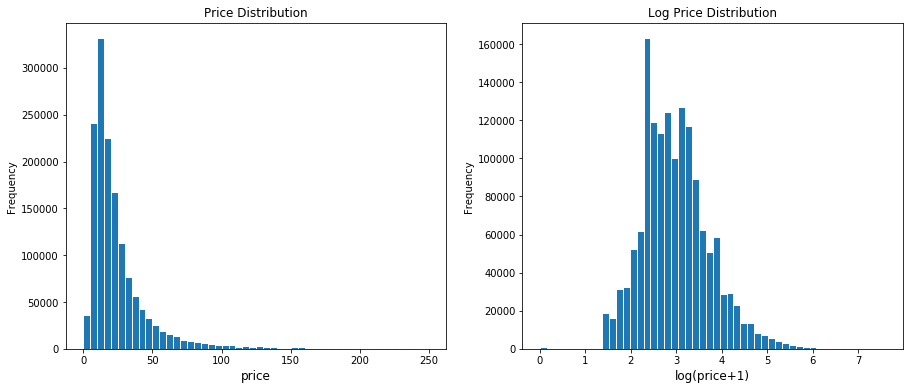

In [17]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(15, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

#Plot Log Price Distribution - NORMAL DISTRIBUTION
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(15,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Log Price Distribution', fontsize=12)

plt.show()

## Remove Items with 0 Price


In [18]:
train[train.price==0]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1325,1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,unknown,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,unknown,0.0,0,"Very simple but cute, a little form fitting as..."
3576,3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,unknown,0.0,1,1 left!
3761,3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,unknown,0.0,1,5 pair gap jean excellent used condition 3 chi...
...,...,...,...,...,...,...,...,...
1474172,1474172,Homecoming or Dama ivory dress,2,"Women/Dresses/Above Knee, Mini",unknown,0.0,0,Ivory formal dress. I wore this dress once for...
1474198,1474198,Tie up flannel top,3,Women/Tops & Blouses/Blouse,unknown,0.0,1,I got this last year and just didnt wear it mu...
1477958,1477958,Rae Dunn Measuring Pear,3,Home/Home Décor/Home Décor Accents,unknown,0.0,0,The dash lid appears it was dropped and a piec...
1478519,1478519,4 pairs women's wool boots socks,1,Women/Shoes/Boots,unknown,0.0,1,✔️SHARE YOUR SOCKS WITH FRIENDS AND FAMILY! ✔️...


In [19]:
# We have 874 items with price of $0. Let's take them out because it looks like an error on their part. 
train[train.price==0].shape

(874, 8)

In [20]:
# Remove items with price of $0 from our training set
train = train[train.price != 0]
train.shape

(1481661, 8)

## Shipping Distribution

In [21]:
train['shipping'].value_counts() / len(train)

0    0.552674
1    0.447326
Name: shipping, dtype: float64

## Price Distribution by Shipping Type

Seems about right. Shipping does increase the price value and confirms our intiution. 

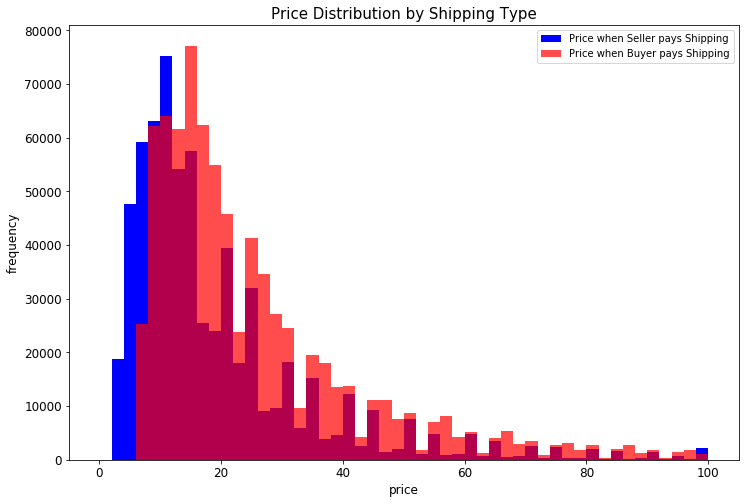

In [22]:
buyer_pay_shipping = train.loc[train['shipping'] == 0, 'price']
seller_pay_shipping = train.loc[train['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(12,8))

ax.hist(seller_pay_shipping, color='blue', alpha=1.0, bins=50, range = [0, 100],label='Price when Seller pays Shipping')
ax.hist(buyer_pay_shipping, color='red', alpha=0.7, bins=50, range = [0, 100],label='Price when Buyer pays Shipping')

plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

## Average Price for Shipping Type

In [23]:
print('The average shipping price if paid by seller is {}'.format(round(seller_pay_shipping.mean(), 2)))
print('The average shipping price if paid by buyer is {}'.format(round(buyer_pay_shipping.mean(), 2)))

The average shipping price if paid by seller is 22.58
The average shipping price if paid by buyer is 30.13


## Top 10 Categories

In [24]:
top_10_category = train['category_name'].value_counts()[:10].reset_index()
top_10_category

,index,category_name
0,"Women/Athletic Apparel/Pants, Tights, Leggings",60152
1,Women/Tops & Blouses/T-Shirts,46349
2,Beauty/Makeup/Face,34320
3,Beauty/Makeup/Lips,29901
4,Electronics/Video Games & Consoles/Games,26547
5,Beauty/Makeup/Eyes,25200
6,"Electronics/Cell Phones & Accessories/Cases, C...",24668
7,Women/Underwear/Bras,21254
8,"Women/Tops & Blouses/Tank, Cami",20270
9,Women/Tops & Blouses/Blouse,20269


## Top 10 Categories Distribution

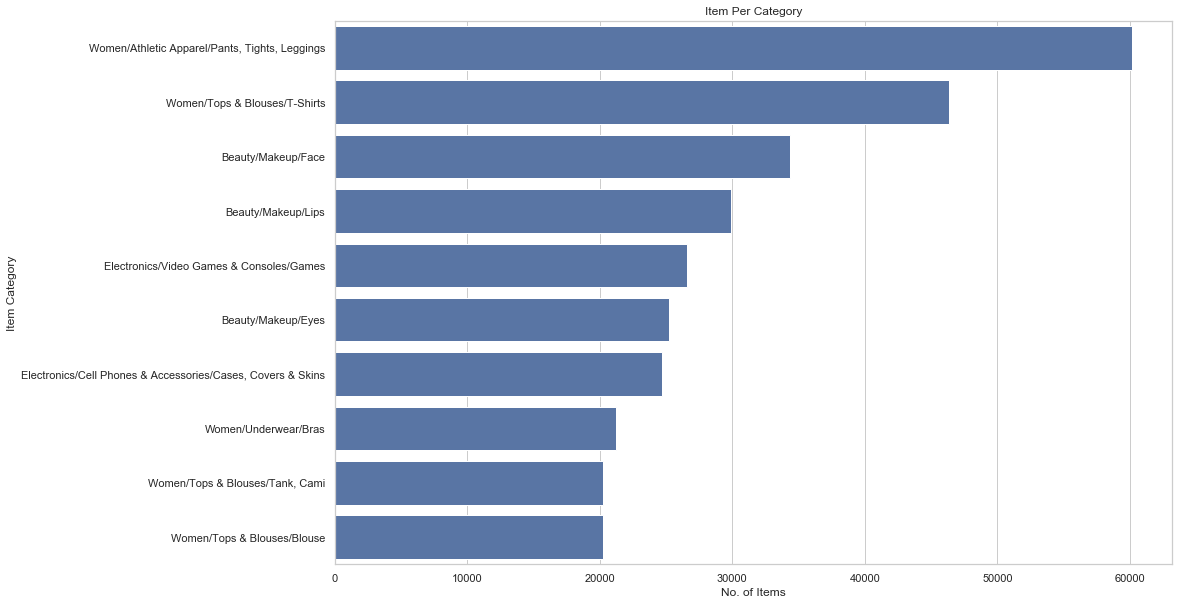

In [25]:
top_10_category = train['category_name'].value_counts()[:10].reset_index().rename(columns={'index': 'category_name', 'category_name':'count'})

sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="count", y='category_name', data=top_10_category, label="# Items", color="b")

ax.set(ylabel="Item Category", title='Item Per Category', xlabel="No. of Items")
plt.show()

## Create new Feature by Splitting Category

There's a format in the category feature: **Root Category/Category/Subcategory**. In the given dataset also it is following the same trend so we need to split the category and save each of them in a separate column.

In [26]:
# Feature Engineering: Creating new Category Features
def transform_category_name(category_name):
    try:
        main, sub1, sub2= category_name.split('/')
        return main, sub1, sub2
    except:
        return 'Other','Other','Other'

In [27]:
train['category_main'], train['category_sub1'], train['category_sub2'] = zip(*train['category_name'].apply(transform_category_name))

cat_train = train[['category_main','category_sub1','category_sub2', 'price']]

cat_train.head()

C:\Users\Mrunal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,category_main,category_sub1,category_sub2,price
0,Men,Tops,T-shirts,10.0
1,Electronics,Computers & Tablets,Components & Parts,52.0
2,Women,Tops & Blouses,Blouse,10.0
3,Home,Home Décor,Home Décor Accents,35.0
4,Women,Jewelry,Necklaces,44.0


# Top 10 Main Category
Women and beauty products make up the most of the items. This is interesting because it allows us to know who are users are, which we can then probably do some sort of targeted marketing...

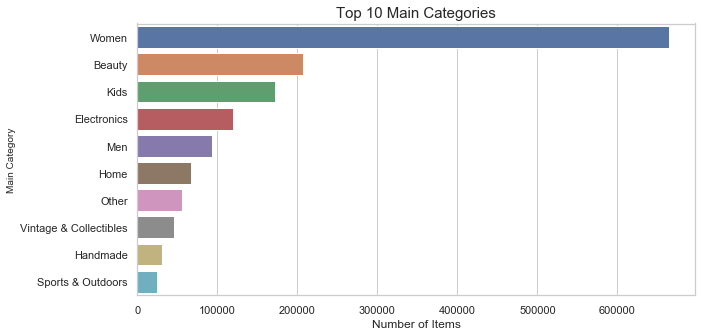

In [28]:
plt.figure(figsize=(10,5))
sns.countplot(y = train['category_main'], order = train['category_main'].value_counts().index, orient = 'v')
plt.title('Top 10 Main Categories', fontsize = 15)
plt.ylabel('Main Category', fontsize = 10)
plt.xlabel('Number of Items')
plt.show()

## Ratio of Main Category 
Women takes up about 45 percent of the main category

In [29]:
train['category_main'].value_counts() * 100/len(train)

Women                     44.813895
Beauty                    14.019739
Kids                      11.578559
Electronics                8.070470
Men                        6.296447
Home                       4.578038
Other                      3.781432
Vintage & Collectibles     3.139652
Handmade                   2.080975
Sports & Outdoors          1.640794
Name: category_main, dtype: float64

## Brand Analysis

There is about 4800 unique brands 

In [30]:
train['brand_name'].nunique()

4808

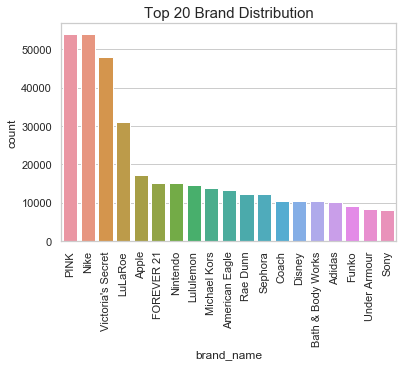

In [31]:
b20 = train['brand_name'].value_counts()[1:20].reset_index().rename(columns={'index': 'brand_name', 'brand_name':'count'})

ax = sns.barplot(x="brand_name", y="count", data=b20)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brand Distribution', fontsize=15)
plt.show()

### Top 20 Expensive Brands

In [32]:
top_20_exp_brand = pd.DataFrame(train.groupby(['brand_name'],as_index=True).std().price.sort_values(ascending=False)[0:20]).reset_index()

In [33]:
top_20_exp_brand

,brand_name,price
0,Demdaco,592.555483
1,Proenza Schouler,420.369183
2,MCM Worldwide,351.470773
3,Saint Laurent,339.769830
4,Celine,339.356795
5,Louis Vuitton,247.801644
6,Goyard,242.051339
7,Sanyo,226.328216
8,MICHELE,224.704134
9,Valentino Garavani,222.253909


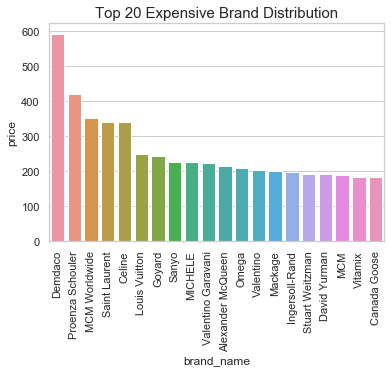

In [34]:
ax = sns.barplot(x="brand_name", y="price", data=top_20_exp_brand)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Expensive Brand Distribution', fontsize=15)
plt.show()

# Length of Description VS Price

Does the length of description have some affect on pricing? 

In [35]:
train['item_description'] = train['item_description'].astype(str)

C:\Users\Mrunal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
descr = train[['name','item_description', 'price']]
descr['count'] = descr['item_description'].apply(lambda x : len(str(x)))
descr.head()

C:\Users\Mrunal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,item_description,price,count
0,MLB Cincinnati Reds T Shirt Size XL,No description yet,10.0,18
1,Razer BlackWidow Chroma Keyboard,This keyboard is in great condition and works ...,52.0,188
2,AVA-VIV Blouse,Adorable top with a hint of lace and a key hol...,10.0,124
3,Leather Horse Statues,New with tags. Leather horses. Retail for [rm]...,35.0,173
4,24K GOLD plated rose,Complete with certificate of authenticity,44.0,41


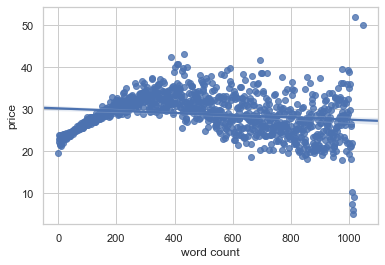

In [37]:
df = descr.groupby('count')['price'].mean().reset_index()
sns.regplot(x=df["count"], y=(df["price"]))
plt.xlabel("word count")
plt.show()

## Initiating NLP procedure

In [38]:
import nltk
import string
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from collections import Counter
import operator
nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mrunal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Text Processing
Normalizing the words by:
- Removing Punctuations
- Removing Stop Words
- Lowercasing the Words
- Stemming / lemmatizing the Words

### Here Removing any characters / numbers and retaining only alphabets can cause change in the meaning and interpretation of text data.

### 'item_description' has numbers and characters, which when removed can alter the data, hence we do not use below code.

train['item_description'] = train['item_description'].apply(lambda x: re.sub("[^a-zA-Z]", " ",x))

In [39]:
stop = set(stopwords.words('english'))
stop.remove('no')
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [40]:
train['item_description'] = train['item_description'].apply(clean)

C:\Users\Mrunal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
train['name'] = train['name'].apply(clean)

C:\Users\Mrunal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Encoding few categorical variables

In [42]:
# Applying LabelBinarizer to "brand_name"
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(train['brand_name'])

# Onehotencoding 'item_condition_id' and 'shipping'
X_dummies = csr_matrix(pd.get_dummies(train[['item_condition_id', 'shipping']], sparse=True).values)

### Vectorizing descriptive features using Count and Tfidf vectorization

In [43]:
cv = CountVectorizer(min_df=10)
X_name = cv.fit_transform(train['name'])
X_category_main = cv.fit_transform(train['category_main'])
X_category_sub1 = cv.fit_transform(train['category_sub1'])
X_category_sub2 = cv.fit_transform(train['category_sub2'])

In [44]:
# Setting maximum features and using ngram range of 2 where we can form 2 word combinations

tv = TfidfVectorizer(max_features=55000, ngram_range =(1, 2), stop_words='english')
X_description = tv.fit_transform(train['item_description'])

In [45]:
print("Item Description Shape: " + str(X_description.shape))

Item Description Shape: (1481661, 55000)


In [46]:
#Checking the weights assigned by TFIDF vectorizer
tfidf = dict(zip(tv.get_feature_names(), tv.idf_))

tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')

tfidf.columns = ['tfidf']

### Tfidf assigns more weightage to rare words, and low weightage for frequent words, check below

In [47]:
#Rare words with high weight
tfidf.sort_values(by=['tfidf'],ascending=False).head(10)

,tfidf
beat beat,12.810780
evod pro,12.723768
3b,12.375462
pairrm pairrm,12.375462
ijust,12.264236
bar bell,12.164153
3ml teeth,12.164153
wide weft,12.164153
led teeth,12.117633
guard shade,12.117633


In [48]:
#frequent words with low weight
tfidf.sort_values(by=['tfidf'],ascending=True).head(10)

,tfidf
new,2.187034
size,2.313928
brand,2.744702
condition,2.790977
brand new,2.883403
free,2.922983
shipping,3.070250
worn,3.111452
used,3.171193
price,3.313649


### Merging all these vectorized and encoded variables together in a SPARSE MATRIX

In [49]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_name, X_category_main, X_category_sub1, X_category_sub2)).tocsr()